In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub, TUDataset
from torch_geometric.utils import to_networkx, scatter, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from icecream import ic

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [4]:
from torch_geometric.datasets import KarateClub


## Pytorch geometric introduction

![](../resources/image.png)

In [5]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
print(edge_index.t())
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(
    x=x, edge_index=edge_index.t().contiguous(), y=torch.tensor([[1], [2], [3]])
)

print("Data")
for key, item in data:
    print(f"{key}:{item}")

data.to(device)

tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])
Data
x:tensor([[-1.],
        [ 0.],
        [ 1.]])
edge_index:tensor([[0, 1],
        [1, 0],
        [1, 2],
        [2, 1]])
y:tensor([[1],
        [2],
        [3]])


Data(x=[3, 1], edge_index=[4, 2], y=[3, 1])

In [6]:
ic(data.x)
ic(data.num_edges, data.num_nodes)
ic(data.has_self_loops())
ic(data.is_directed())
ic(data.has_isolated_nodes())

ic| data.x: tensor([[-1.],
                    [ 0.],
                    [ 1.]], device='mps:0')
ic| data.num_edges: 2, data.num_nodes: 3
ic| data.has_self_loops(): False
ic| data.is_directed(): False
ic| data.has_isolated_nodes(): False


False

# Batchs of multiple graphs

Adjacency matrix is defined by edge_index.

\begin{split}\mathbf{A} = \begin{bmatrix} \mathbf{A}_1 & & \\ & \ddots & \\ & & \mathbf{A}_n \end{bmatrix}, \qquad \mathbf{X} = \begin{bmatrix} \mathbf{X}_1 \\ \vdots \\ \mathbf{X}_n \end{bmatrix}, \qquad \mathbf{Y} = \begin{bmatrix} \mathbf{Y}_1 \\ \vdots \\ \mathbf{Y}_n \end{bmatrix}\end{split}

We take batches size of graphs. 32 means we take batches of 32 graphs. Each graph as a y (a type)

In [7]:
tu_ds = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")  # , use_node_attr=True)
tu_ds
ic("Nb of graphs in the dataset", len(tu_ds))

ic(tu_ds.y);


Processing...
Done!
ic| 'Nb of graphs in the dataset', len(tu_ds): 600
ic| tu_ds.y: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
                     4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

torch.Size([19580, 3])

In [9]:
ic(
    tu_ds.num_node_attributes,
    tu_ds.num_node_features,
    tu_ds.num_classes,
    tu_ds.num_edge_features,
)
ic(
    "One graph", tu_ds[0]
)  # Contains 37 nodes, each one with 3 features. There are 168/2=84 undirected edges. the graph is assigned to 1 class (y)
# One can shuffle the dataset
tu_ds.shuffle()

ic| tu_ds.num_node_attributes: 18
    tu_ds.num_node_features: 3
    tu_ds.num_classes: 6
    tu_ds.num_edge_features: 0
ic| 'One graph', tu_ds[0]: Data(edge_index=[2, 168], x=[37, 3], y=[1])


ENZYMES(600)

In [10]:
loader = DataLoader(tu_ds, batch_size=32, shuffle=True)
for batch in loader:
    ic(batch)
    ic(
        batch.batch.shape,
        "the batch vector contains the index of the graph to which each node belongs",
        batch.batch.unique(),
        "contains up to 32 (batch_size) unique values",
    )
    ic(batch.x.shape)
    ic(batch.num_graphs)
    ic(batch.y.shape)

    break


ic| batch: DataBatch(edge_index=[2, 3832], x=[985, 3], y=[32], batch=[985], ptr=[33])
ic| batch.batch.shape: torch.Size([985])
    "the batch vector contains the index of the graph to which each node belongs": 'the batch vector contains the index of the graph to which each node belongs'
    batch.batch.unique(): tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                                  18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])
    "contains up to 32 (batch_size) unique values": 'contains up to 32 (batch_size) unique values'
ic| batch.x.shape: torch.Size([985, 3])
ic| batch.num_graphs: 32
ic| batch.y.shape: torch.Size([32])


In [11]:
def plot_graph(G, figsize=(10, 7), node_color="lightblue", edge_color="gray"):
    plt.figure(figsize=figsize)
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color=node_color,
        edge_color=edge_color,
        cmap="Set2",
    )


/Users/jkunz/Projects/cop_gnn/.venv/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


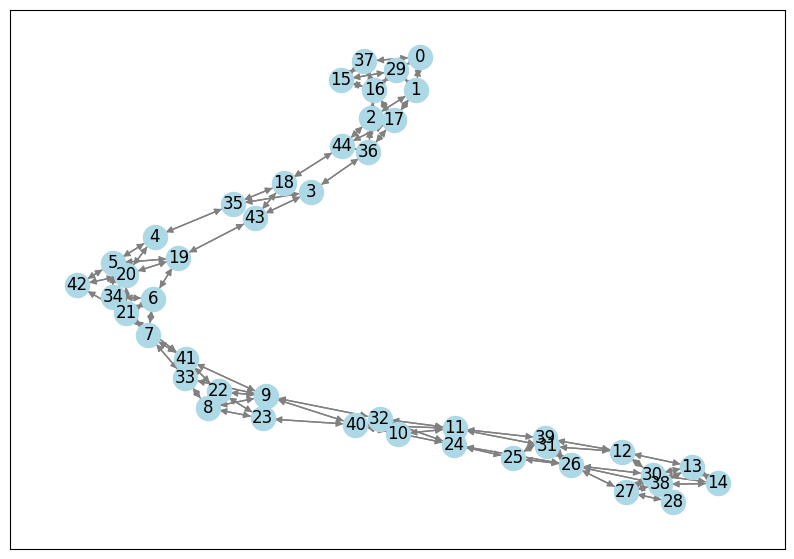

In [12]:
# we show the first graph in the dataset
tuG = to_networkx(tu_ds[100])
plot_graph(tuG)


## Simple node embeddings (Karate club)



ic| len(dataset): 1


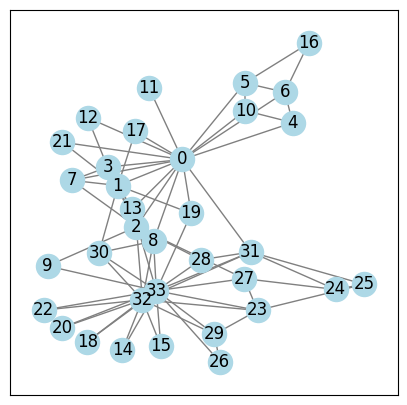

In [13]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]


G = to_networkx(data, to_undirected=True)

plot_graph(G, figsize=(5, 5))
ic(len(dataset));

In [28]:
dataset.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [14]:
# torch geometric -> adjacency matrix
adj_matrix = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes)
# 3d tensor with batch dimension first
ic(adj_matrix.shape, adj_matrix);

ic| adj_matrix.shape: torch.Size([1, 34, 34])
    adj_matrix: tensor([[[0., 1., 1.,  ..., 1., 0., 0.],
                         [1., 0., 1.,  ..., 0., 0., 0.],
                         [1., 1., 0.,  ..., 0., 1., 0.],
                         ...,
                         [1., 0., 0.,  ..., 0., 1., 1.],
                         [0., 0., 1.,  ..., 1., 0., 1.],
                         [0., 0., 0.,  ..., 1., 1., 0.]]])


In [15]:
# compute adjacency matrix
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list
labels = data.y.numpy()  # Community labels (0 or 1)

# Construct adjacency matrix (without self-loops for neighborhood computation)
A = torch.zeros((num_nodes, num_nodes))
A[edge_index[0], edge_index[1]] = 1  # Undirected graph

edge_index[0], edge_index[1]
# matrix is symmetric
A[0,] == A[:, 0]
ic(A.shape, A);

ic| A.shape: torch.Size([34, 34])
    A: tensor([[0., 1., 1.,  ..., 1., 0., 0.],
               [1., 0., 1.,  ..., 0., 0., 0.],
               [1., 1., 0.,  ..., 0., 1., 0.],
               ...,
               [1., 0., 0.,  ..., 0., 1., 1.],
               [0., 0., 1.,  ..., 1., 0., 1.],
               [0., 0., 0.,  ..., 1., 1., 0.]])


In [16]:
i = 0
j = 1
neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
neighbors_i
A[0].nonzero(as_tuple=True)[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [20]:
# Compute Jaccard similarity matrix
def compute_jaccard_similarity(A):
    S = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):  # Symmetric matrix, compute upper triangle
            neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
            neighbors_j = set(A[j].nonzero(as_tuple=True)[0].tolist())
            intersection = len(neighbors_i & neighbors_j)
            union = len(neighbors_i | neighbors_j)
            if union > 0:  # Avoid division by zero
                sim = intersection / union
                S[i, j] = sim
                S[j, i] = sim  # Symmetry
    # No self-loops in Jaccard (typically similarity to self is not 1 unless defined)
    return S


# S = compute_jaccard_similarity(adj_matrix.squeeze(0))  # remove batch dimension
S = compute_jaccard_similarity(A)
print("Jaccard similarity matrix sample:\n", S)  # S[:5, :5])


Jaccard similarity matrix sample:
 tensor([[1.0000, 0.3889, 0.2381,  ..., 0.0000, 0.1200, 0.1379],
        [0.3889, 1.0000, 0.2667,  ..., 0.0714, 0.1053, 0.1304],
        [0.2381, 0.2667, 1.0000,  ..., 0.2308, 0.0476, 0.2857],
        ...,
        [0.0000, 0.0714, 0.2308,  ..., 1.0000, 0.0588, 0.0952],
        [0.1200, 0.1053, 0.0476,  ..., 0.0588, 1.0000, 0.5263],
        [0.1379, 0.1304, 0.2857,  ..., 0.0952, 0.5263, 1.0000]])


In [30]:
# use A as similarity measure
S = A

In [32]:
# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16
node_ids = torch.arange(num_nodes)
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameter for L2 regularization
lambda_reg = 0.01  # Regularization strength


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    recon_loss = torch.norm(S_hat - S, p="fro") ** 2

    # L2 regularization: lambda * ||Z||^2
    l2_reg = lambda_reg * torch.norm(Z, p="fro") ** 2

    loss = recon_loss + l2_reg

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(5000):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 28684.5820
Epoch 100, Loss: 2352.6802
Epoch 200, Loss: 692.5881
Epoch 300, Loss: 320.6485
Epoch 400, Loss: 191.0832
Epoch 500, Loss: 134.4165
Epoch 600, Loss: 105.8126
Epoch 700, Loss: 90.0030
Epoch 800, Loss: 80.7735
Epoch 900, Loss: 75.1753
Epoch 1000, Loss: 71.6684
Epoch 1100, Loss: 69.4100
Epoch 1200, Loss: 67.9219
Epoch 1300, Loss: 66.9223
Epoch 1400, Loss: 66.2398
Epoch 1500, Loss: 65.7669
Epoch 1600, Loss: 65.4346
Epoch 1700, Loss: 65.1980
Epoch 1800, Loss: 65.0272
Epoch 1900, Loss: 64.9025
Epoch 2000, Loss: 64.8102
Epoch 2100, Loss: 64.7412
Epoch 2200, Loss: 64.6891
Epoch 2300, Loss: 64.6493
Epoch 2400, Loss: 64.6187
Epoch 2500, Loss: 64.5950
Epoch 2600, Loss: 64.5764
Epoch 2700, Loss: 64.5619
Epoch 2800, Loss: 64.5503
Epoch 2900, Loss: 64.5412
Epoch 3000, Loss: 64.5338
Epoch 3100, Loss: 64.5279
Epoch 3200, Loss: 64.5231
Epoch 3300, Loss: 64.5193
Epoch 3400, Loss: 64.5161
Epoch 3500, Loss: 64.5135
Epoch 3600, Loss: 64.5113
Epoch 3700, Loss: 64.5095
Epoch 3800, Lo

In [27]:
# TODO
# predictive model of node
data.y
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
node_ids.shape, data.y.shape, Z.shape

(torch.Size([34]), torch.Size([34]), torch.Size([34, 16]))

ic| X_train.shape: (27, 16)
    X_test.shape: (7, 16)
    y_train.shape: (27,)
    y_test.shape: (7,)


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



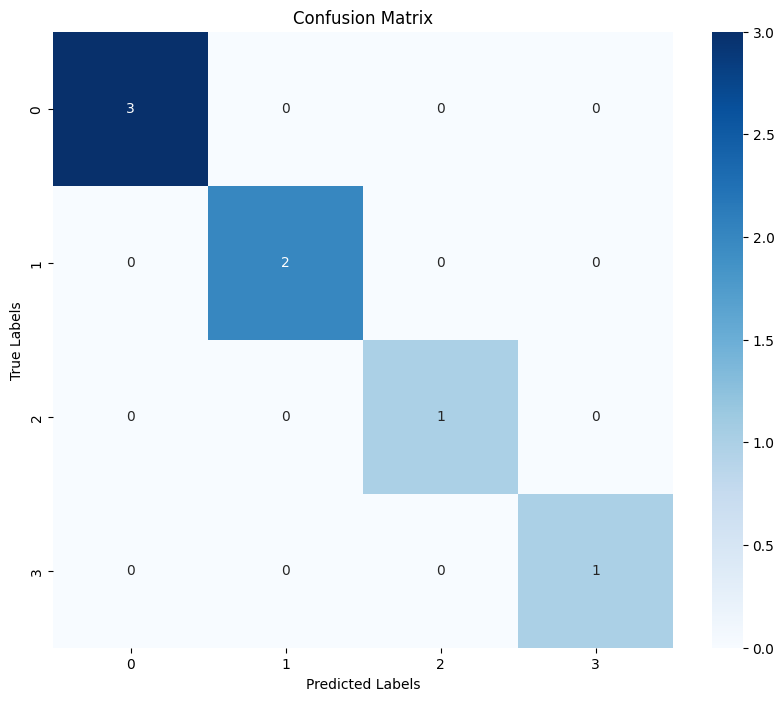

/Users/jkunz/Projects/cop_gnn/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(



Cross-Validation Accuracy: 0.8524 ± 0.0909


In [33]:
# Import necessary libraries
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming Z_np contains the node embeddings and data.y contains the labels
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    Z_np, data.y.numpy(), test_size=0.2, random_state=42, stratify=data.y.numpy()
)
ic(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Perform cross-validation to get a more robust estimate of model performance
cv_scores = cross_val_score(rf_model, Z_np, data.y.numpy(), cv=5)
print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


## Add a link prediction

In [49]:
left_emb = Z[data.edge_index[0]]
right_emb = Z[data.edge_index[1]]

ic(left_emb.shape, right_emb.shape)
torch.cat([left_emb, right_emb],dim=1).shape


ic| left_emb.shape: torch.Size([156, 16])
    right_emb.shape: torch.Size([156, 16])


torch.Size([156, 32])

## Data visualisation

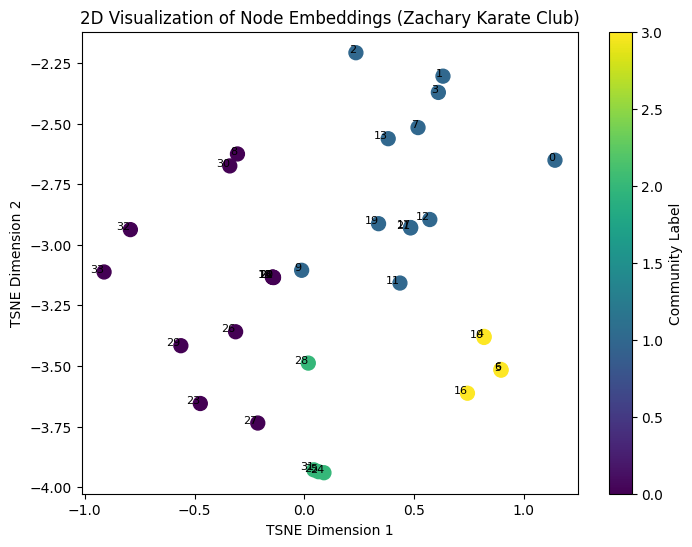

In [36]:
# Reduce embeddings to 2D using TSNE
Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

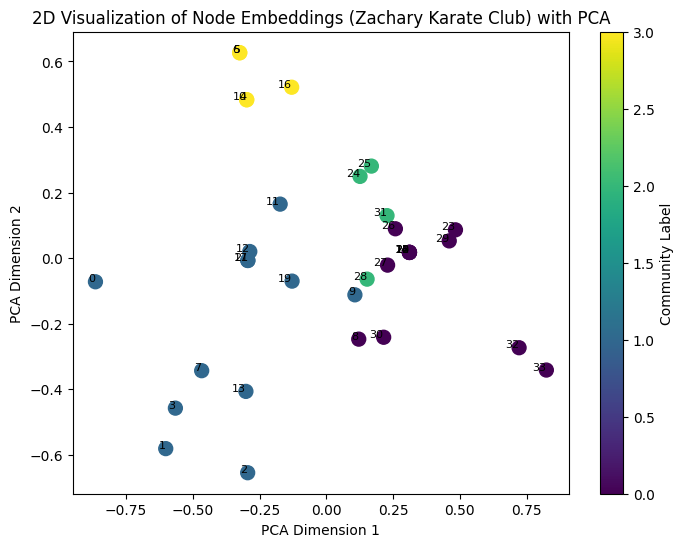

In [37]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club) with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()